# Field Award Factorization Machine

## Modules

In [1]:
import csv
import random
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

/tmp/ipykernel_1360438/3928242427.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/opt/conda/envs/py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Seed

In [2]:
###############################################################################
# 주어진 결과와 정확히 비교하기 위한 random seed 고정
###############################################################################
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data preprocessing
0. Dataset 다운로드  
<br/>
1. Rating df 생성  
rating 데이터(train_ratings.csv)를 불러와 [user, item, rating]의 컬럼으로 구성된 데이터 프레임을 생성합니다.   
<br/>
2. Genre df 생성   
genre 정보가 담긴 데이터(genres.tsv)를 불러와 genre이름을 id로 변경하고, [item, genre]의 컬럼으로 구성된 데이터 프레임을 생성합니다.    
<br/>
3. Negative instances 생성   
rating 데이터는 implicit feedback data(rating :0/1)로, positive instances로 구성되어 있습니다. 따라서 rating이 없는 item중 negative instances를 뽑아서 데이터에 추가하게 됩니다.   
<br/>
4. Join dfs   
rating df와 genre df를 join하여 [user, item, rating, genre]의 컬럼으로 구성된 데이터 프레임을 생성합니다.   
<br/>
5. zero-based index로 mapping   
Embedding을 위해서 user,item,genre를 zero-based index로 mapping합니다.
    - user : 0-31359
    - item : 0-6806
    - genre : 0-17  
<br/>
6. feature matrix X, label tensor y 생성   
[user, item, genre] 3개의 field로 구성된 feature matrix를 생성합니다.   
<br/>
7. data loader 생성

In [3]:
# 1. Rating df 생성
rating_data = "../../data/train/train_ratings.csv"

raw_rating_df = pd.read_csv(rating_data)
raw_rating_df
raw_rating_df['rating'] = 1.0 # implicit feedback
raw_rating_df.drop(['time'],axis=1,inplace=True)
print("Raw rating df")
print(raw_rating_df)

users = set(raw_rating_df.loc[:, 'user'])
items = set(raw_rating_df.loc[:, 'item'])

#2. Genre df 생성
genre_data = "../../data/train/genres.tsv"

raw_genre_df = pd.read_csv(genre_data, sep='\t')
raw_genre_df = raw_genre_df.drop_duplicates(subset=['item']) #item별 하나의 장르만 남도록 drop
# print(raw_genre_df)

genre_dict = {genre:i for i, genre in enumerate(set(raw_genre_df['genre']))}
raw_genre_df['genre']  = raw_genre_df['genre'].map(lambda x : genre_dict[x]) #genre id로 변경
print("Raw genre df - changed to id")
print(raw_genre_df)

Raw rating df
           user   item  rating
0            11   4643     1.0
1            11    170     1.0
2            11    531     1.0
3            11    616     1.0
4            11   2140     1.0
...         ...    ...     ...
5154466  138493  44022     1.0
5154467  138493   4958     1.0
5154468  138493  68319     1.0
5154469  138493  40819     1.0
5154470  138493  27311     1.0

[5154471 rows x 3 columns]
Raw genre df - changed to id
         item  genre
0         318      0
2        2571     16
5        2959     16
9         296     12
13        356     12
...       ...    ...
15925   73106     12
15926  109850     16
15929    8605     16
15931    3689     12
15932    8130      3

[6807 rows x 2 columns]


In [4]:
# 3. Negative instance 생성

# 시청횟수를 기준으로 raw_genre_df를 오름차순으로 정렬하고, 시청횟수가 적은 500개 아이템을 선택합니다.
# items_few_views = set(raw_genre_df.sort_values(by='views')['item'].head(500))

print("Create Nagetive instances")
num_negative = 50
user_group_dfs = list(raw_rating_df.groupby('user')['item'])
first_row = True
user_neg_dfs = pd.DataFrame()

for u, u_items in tqdm(user_group_dfs):
    u_items = set(u_items)
    i_user_neg_item = np.random.choice(list(items - u_items), num_negative, replace=False)
    
    i_user_neg_df = pd.DataFrame({'user': [u]*num_negative, 'item': i_user_neg_item, 'rating': [0]*num_negative})
    if first_row == True:
        user_neg_dfs = i_user_neg_df
        first_row = False
    else:
        user_neg_dfs = pd.concat([user_neg_dfs, i_user_neg_df], axis = 0, sort=False)

raw_rating_df = pd.concat([raw_rating_df, user_neg_dfs], axis = 0, sort=False)

# 4. Join inter_df, genre_df dfs
joined_rating_df = pd.merge(raw_rating_df, raw_genre_df, left_on='item', right_on='item', how='inner')
print("Joined rating df")
print(joined_rating_df)

# 5. user, item을 zero-based index로 mapping
users = list(set(joined_rating_df.loc[:,'user']))
users.sort()
items =  list(set((joined_rating_df.loc[:, 'item'])))
items.sort()
genres =  list(set((joined_rating_df.loc[:, 'genre'])))
genres.sort()

# user 인덱싱
if len(users)-1 != max(users):
    users_dict = {users[i]: i for i in range(len(users))}
    joined_rating_df['user']  = joined_rating_df['user'].map(lambda x : users_dict[x])
    users = list(set(joined_rating_df.loc[:,'user']))
# item 인덱싱    
if len(items)-1 != max(items):
    items_dict = {items[i]: i for i in range(len(items))}
    joined_rating_df['item']  = joined_rating_df['item'].map(lambda x : items_dict[x])
    items =  list(set((joined_rating_df.loc[:, 'item'])))

joined_rating_df = joined_rating_df.sort_values(by=['user'])
joined_rating_df.reset_index(drop=True, inplace=True)

data = joined_rating_df
print("Data")
print(data)

n_data = len(data)
n_user = len(users)
n_item = len(items)
n_genre = len(genres)

print("# of data : {}\n# of users : {}\n# of items : {}\n# of genres : {}".format(n_data, n_user, n_item, n_genre))

Create Nagetive instances


100%|██████████| 31360/31360 [06:15<00:00, 83.57it/s] 


Joined rating df
           user   item  rating  genre
0            11   4643     1.0     16
1            11    170     1.0     16
2            11    531     1.0      7
3            11    616     1.0      6
4            11   2140     1.0     11
...         ...    ...     ...    ...
6722466  138493  39715     0.0     12
6722467  138493    718     0.0     12
6722468  138493   6436     0.0      9
6722469  138493   3189     0.0      7
6722470  138493   4339     0.0     16

[6722471 rows x 4 columns]
Data
          user  item  rating  genre
0            0  5207     0.0     16
1            0  2812     1.0     16
2            0  3989     1.0     16
3            0   353     1.0     16
4            0   687     1.0     16
...        ...   ...     ...    ...
6722466  31359  5217     0.0     16
6722467  31359   784     0.0     16
6722468  31359  6516     0.0     12
6722469  31359  6467     0.0      0
6722470  31359  3123     0.0     12

[6722471 rows x 4 columns]
# of data : 6722471
# of users : 3

In [5]:
data = joined_rating_df[['user', 'item', 'genre', 'rating']]
data

,user,item,genre,rating
0,0,5207,16,0.0
1,0,2812,16,1.0
2,0,3989,16,1.0
3,0,353,16,1.0
4,0,687,16,1.0
...,...,...,...,...
6722466,31359,5217,16,0.0
6722467,31359,784,16,0.0
6722468,31359,6516,12,0.0
6722469,31359,6467,0,0.0


## FFM Architecture

In [6]:
class FeaturesLinear(nn.Module):

    def __init__(self, field_dims: np.ndarray, output_dim: int=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64)
        
        # self.linear = nn.Linear(input_dim, 1, bias=True)
        #linear(x)
    def forward(self, x: torch.Tensor):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)`` = (256,9)
        :return : (batch_size, output_dim=1)
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0) #[256,9]
        return torch.sum(self.fc(x), dim=1) + self.bias #self.fc(x) = (256,9,1) #self.bias = [0.] => [256,1]

In [7]:
class FieldAwareFactorizationMachine(nn.Module):

    def __init__(self, field_dims: np.ndarray, embed_dim: int):
        super().__init__()
        self.num_fields = len(field_dims)
        self.embeddings = torch.nn.ModuleList([
            torch.nn.Embedding(sum(field_dims), embed_dim) for _ in range(self.num_fields)
        ])
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64)
        for embedding in self.embeddings:
            torch.nn.init.xavier_uniform_(embedding.weight.data)

    def forward(self, x: torch.Tensor):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)`` #[256,9]
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        xs = [self.embeddings[i](x) for i in range(self.num_fields)]
        ix = list()
        for i in range(self.num_fields - 1):
            for j in range(i + 1, self.num_fields):
                ix.append(xs[j][:, i] * xs[i][:, j])
        ix = torch.stack(ix, dim=1)
        
        return ix #[256,36,8]

In [8]:
class FieldAwareFactorizationMachineModel(nn.Module):

    def __init__(self, field_dims: np.ndarray, embed_dim: int):
        super().__init__()
        self.linear = FeaturesLinear(field_dims)
        self.ffm = FieldAwareFactorizationMachine(field_dims, embed_dim)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, FieldAwareFactorizationMachine):
                nn.init.normal_(m.v, 0, 0.01)
        
    def forward(self, x: torch.Tensor):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        ffm_term = torch.sum(torch.sum(self.ffm(x), dim=1), dim=1, keepdim=True)
        x = self.linear(x) + ffm_term
        return torch.sigmoid(x.squeeze(1))

## train, test 함수

In [9]:
def train(model, data_loader, criterion, optimizer, device):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y.float())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        if batch % 1000 == 0:
            loss = loss.item()
            current = batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    
    return train_loss

In [10]:
from sklearn.metrics import roc_auc_score

def test(model, data_loader, criterion, device, task='clf'):
    num_batches = len(data_loader)
    test_loss, y_all, pred_all = 0, list(), list()

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y.float()).item() / num_batches
            y_all.append(y)
            pred_all.append(pred)

    y_all = torch.cat(y_all).cpu()
    pred_all = torch.cat(pred_all).cpu()

    if task == 'reg':
        err = abs(pred_all - y_all).type(torch.float).mean().item()
        print(f"Test Error: \n  MAE: {(err):>8f} \n  Avg loss: {test_loss:>8f}")
    else:
        err = roc_auc_score(y_all, torch.sigmoid(pred_all)).item()
        print(f"Test Error: \n  AUC: {err:>8f} \n  Avg loss: {test_loss:>8f}")

    return err, test_loss

## 하이퍼파라미터 설정 

In [11]:
ffm_field_dims = np.array([len(users_dict), len(items_dict), len(genre_dict)]) #, dtype=np.uint32)

In [13]:
######## Hyperparameter ########
batch_size = 1024 # 배치 사이즈
data_shuffle = True
embed_dim = 8 # embed feature의 dimension
epochs = 5 # epoch 돌릴 횟수
learning_rate = 0.01 # 학습이 반영되는 정도를 나타내는 파라미터
weight_decay=1e-6 # 정규화를 위한 파라미터
seed=42

# device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
# print("Capturing:", torch.cuda.is_current_stream_capturing())
print(device)

cuda


## 데이터셋 생성

In [14]:
user_col = torch.tensor(data.loc[:,'user'])
item_col = torch.tensor(data.loc[:,'item'])
genre_col = torch.tensor(data.loc[:,'genre'])

X = torch.cat([user_col.unsqueeze(1), item_col.unsqueeze(1), genre_col.unsqueeze(1)], dim=1)
y = torch.tensor(list(data.loc[:,'rating']))

In [15]:
#7. data loader 생성
# 훈련 데이터셋은 미니배치 크기가 1024이고, 테스트 데이터셋은 미니배치 크기가 512인 미니배치로 분할
# 훈련 데이터는 에폭마다 shuffle, 다양한 미니배치로 모델 훈련. 테스트 데이터는 섞이지 않고 유지

class RatingDataset(Dataset):
    def __init__(self, input_tensor, target_tensor):
        self.input_tensor = input_tensor.long()
        self.target_tensor = target_tensor.long()

    def __getitem__(self, index):
        return self.input_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.target_tensor.size(0)


dataset = RatingDataset(X, y)
train_ratio = 0.9

train_size = int(train_ratio * len(data))
test_size = len(data) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

## Train & Test

In [16]:
criterion = torch.nn.BCEWithLogitsLoss()
model = FieldAwareFactorizationMachineModel(ffm_field_dims, embed_dim).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, amsgrad=True, weight_decay=weight_decay)

train_loss, test_err, test_loss = list(), list(), list()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train(model, train_loader, criterion, optimizer, device))
    test_result = test(model, test_loader, criterion, device)
    test_err.append(test_result[0])
    test_loss.append(test_result[1])
    print("-------------------------------\n")
print("Done!")

Epoch 1
-------------------------------
loss: 0.596841 [    0/6050223]
loss: 0.492047 [1024000/6050223]
loss: 0.475451 [2048000/6050223]
loss: 0.459692 [3072000/6050223]
loss: 0.455046 [4096000/6050223]
loss: 0.451709 [5120000/6050223]
Test Error: 
  AUC: 0.902993 
  Avg loss: 0.468398
-------------------------------

Epoch 2
-------------------------------
loss: 0.471263 [    0/6050223]
loss: 0.470826 [1024000/6050223]
loss: 0.462606 [2048000/6050223]
loss: 0.470256 [3072000/6050223]
loss: 0.451746 [4096000/6050223]
loss: 0.457272 [5120000/6050223]
Test Error: 
  AUC: 0.901876 
  Avg loss: 0.467548
-------------------------------

Epoch 3
-------------------------------
loss: 0.471089 [    0/6050223]
loss: 0.460546 [1024000/6050223]
loss: 0.463729 [2048000/6050223]
loss: 0.471000 [3072000/6050223]
loss: 0.458164 [4096000/6050223]
loss: 0.464772 [5120000/6050223]
Test Error: 
  AUC: 0.900976 
  Avg loss: 0.467338
-------------------------------

Epoch 4
-------------------------------


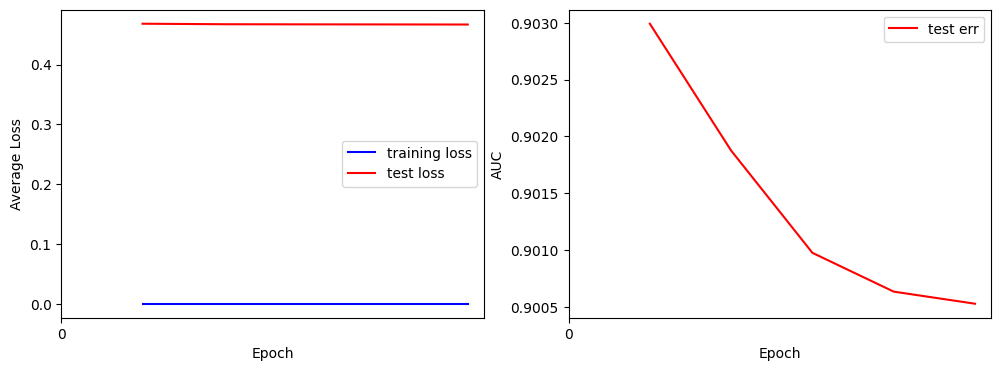

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (loss_ax, err_ax) = plt.subplots(1,2, figsize=(12,4))

loss_ax.plot(range(1,epochs+1), train_loss, 'b', label='training loss')
loss_ax.plot(range(1,epochs+1), test_loss, 'r', label='test loss')
err_ax.plot(range(1,epochs+1), test_err, 'r', label='test err')

loss_ax.set_xticks(range(0, epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

err_ax.set_xticks(range(0, epochs+1, 10))
err_ax.set_xlabel('Epoch')
err_ax.set_ylabel('AUC')
err_ax.legend()

plt.show()

## Infernece

In [ ]:
# 모든 유저-아이템을 인풋으로 넣어서 결과 생성 후 랭킹 (31360 x 6807)
u_list = []
i_list = []
ritems_dict = {v:k for k,v in items_dict.items()}
for u, u_items in tqdm(user_group_dfs):

    # 인코딩하기 전에 유저id 저장
    u_list.append([u]*10)

    # user incoding
    u = users_dict[u]
    u_items = set(u_items.map(lambda x : items_dict[x])) # incoding된 유저의 시청 아이템

    # user, item, genre 데이터를 인코딩하여 학습한 모델에 맞는 값으로 변환
    i_user_col = torch.tensor([u] * n_item)
    i_item_col = torch.tensor(raw_genre_df['item'].map(lambda x : items_dict[x]).values)
    i_genre_col = torch.tensor(raw_genre_df['genre'].values)
    
    x = torch.cat([i_user_col.unsqueeze(1), i_item_col.unsqueeze(1), i_genre_col.unsqueeze(1)], dim=1)
    x = x.to(device)

    model.eval()
    output_batch = model(x)
    output_batch = output_batch.cpu().detach().numpy()

    output_batch[list(u_items)] = -1    # 이미 본 아이템 제외
    result_batch = np.argsort(output_batch)[-10:][::-1] # Top 10 item_id 추출
    i_list.append(list(map(lambda x : ritems_dict[x], result_batch)))   # item decoding

100%|██████████| 31360/31360 [02:42<00:00, 193.55it/s]


In [22]:
import os
u_list = np.concatenate(u_list)
i_list = np.concatenate(i_list)
submit_df = pd.DataFrame(data={'user': u_list, 'item': i_list}, columns=['user', 'item'])
submit_df.to_csv("FFM_submission_v3.csv", index=False)